In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
ops.reset_default_graph()

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('temp', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp\train-labels-idx1-ubyte.gz
Extracting temp\t10k-images-idx3-ubyte.gz
Extracting temp\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_set = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_set = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])
train_labels = mnist.train.labels
test_labels = mnist.test.labels

In [4]:
train_set_n = np.array([np.reshape(x, (28,28)) for x in train_set])
test_set_n = np.array([np.reshape(x, (28,28)) for x in test_set])

In [5]:
train_set[0].shape

(28, 28)

In [6]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = 28
image_height = 28
target_size = int(np.max(train_labels) + 1)
num_channels = 1 
generations = 2000
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2 
max_pool_size2 = 2 
fully_connected_size1 = 100

In [7]:
# calculate prediction accuracy 
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return 100. * num_correct/batch_predictions.shape[0]

## Model 1 fully_connect_1 -> fully_connect_2 -> predictions

In [8]:
def model_1_build(input_data, full1_weight, full1_bias, full2_weight, full2_bias):
    # Transform data to 1*N for fully connected NN
    input_data_shape = input_data.get_shape().as_list()
    modified_shape = input_data_shape[1] * input_data_shape[2] * input_data_shape[3]
    flat_data = tf.reshape(input_data, [input_data_shape[0], modified_shape])

    # Fully Connected Layer 1
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_data, full1_weight), full1_bias))

    # Fully Connected Layer 2
    model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    return model_output

In [9]:
def model_1(train_data, train_labels, test_data, test_labels, generations):
    sess = tf.Session()
    # set up placeholders
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    # set up variables
    resulting_width = image_width
    resulting_height = image_height
    full1_input_size = resulting_width * resulting_height
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
    
    # outputs and loss
    model_output = model_1_build(x_input, full1_weight, full1_bias, full2_weight, full2_bias)
    test_model_output = model_1_build(eval_input, full1_weight, full1_bias, full2_weight, full2_bias)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    # Initialize Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('model 1 (full_conn_1 -> full_connect_2 -> predictions)')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(test_data), size=evaluation_size)
            eval_x = test_data[eval_index]
            eval_x = np.expand_dims(eval_x, 3)
            eval_y = test_labels[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        if (i+1) % 200 == 0:
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    sess.close()
    return train_loss, train_acc, test_acc


In [10]:
%%time
train_loss_1, train_acc_1, test_acc_1 = model_1(train_set_n, train_labels, test_set_n, test_labels, generations)

model 1 (full_conn_1 -> full_connect_2 -> predictions)
Generation # 200. Train Loss: 0.57. Train Acc (Test Acc): 82.00 (84.40)
Generation # 400. Train Loss: 0.40. Train Acc (Test Acc): 90.00 (88.20)
Generation # 600. Train Loss: 0.32. Train Acc (Test Acc): 91.00 (90.60)
Generation # 800. Train Loss: 0.22. Train Acc (Test Acc): 94.00 (91.20)
Generation # 1000. Train Loss: 0.27. Train Acc (Test Acc): 90.00 (92.20)
Generation # 1200. Train Loss: 0.25. Train Acc (Test Acc): 94.00 (92.20)
Generation # 1400. Train Loss: 0.47. Train Acc (Test Acc): 88.00 (92.60)
Generation # 1600. Train Loss: 0.30. Train Acc (Test Acc): 88.00 (91.60)
Generation # 1800. Train Loss: 0.23. Train Acc (Test Acc): 94.00 (93.00)
Generation # 2000. Train Loss: 0.22. Train Acc (Test Acc): 93.00 (93.60)
Wall time: 6.79 s


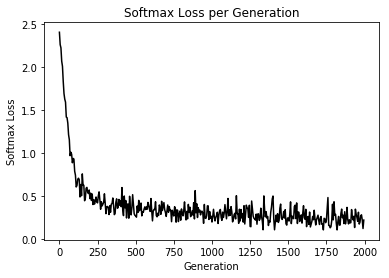

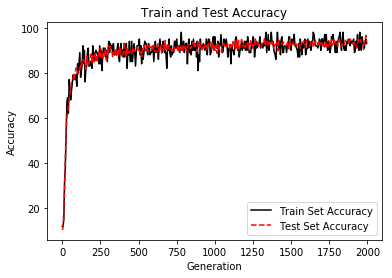

In [11]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss_1, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc_1, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc_1, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Model 2 Convol - Maxpool - fully_connect_1 - fully_connect_2 -> predictions

In [12]:
def model_2_build(input_data, conv1_weight, conv1_bias, full1_weight, full1_bias, full2_weight, full2_bias):

    
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    final_conv_shape = max_pool1.get_shape().as_list()
    modified_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_data = tf.reshape(max_pool1, [final_conv_shape[0], modified_shape])
    
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_data, full1_weight), full1_bias))
    
    model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    return model_output

In [13]:
def model_2(train_data, train_labels, test_data, test_labels, generations):
    sess = tf.Session()
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
    conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

    resulting_width = image_width // max_pool_size1
    resulting_height = image_height // max_pool_size1 
    full1_input_size = resulting_width * resulting_height * conv1_features
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
    
    model_output = model_2_build(x_input, conv1_weight, conv1_bias,full1_weight, full1_bias, full2_weight, full2_bias)
    test_model_output = model_2_build(eval_input, conv1_weight, conv1_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('Model 2 (Convol -> Maxpool -> fully_connect_1 -> fully_connect_2 -> predictions')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(test_data), size=evaluation_size)
            eval_x = test_data[eval_index]
            eval_x = np.expand_dims(eval_x, 3)
            eval_y = test_labels[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        if (i+1) % 200 == 0:
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    sess.close()
    return train_loss, train_acc, test_acc


In [14]:
%%time
train_loss_2, train_acc_2, test_acc_2 = model_2(train_set_n, train_labels, test_set_n, test_labels, generations)

Model 2 (Convol -> Maxpool -> fully_connect_1 -> fully_connect_2 -> predictions
Generation # 200. Train Loss: 0.41. Train Acc (Test Acc): 90.00 (91.20)
Generation # 400. Train Loss: 0.19. Train Acc (Test Acc): 95.00 (93.20)
Generation # 600. Train Loss: 0.27. Train Acc (Test Acc): 93.00 (94.80)
Generation # 800. Train Loss: 0.35. Train Acc (Test Acc): 89.00 (94.00)
Generation # 1000. Train Loss: 0.18. Train Acc (Test Acc): 95.00 (94.80)
Generation # 1200. Train Loss: 0.19. Train Acc (Test Acc): 96.00 (94.80)
Generation # 1400. Train Loss: 0.18. Train Acc (Test Acc): 92.00 (96.20)
Generation # 1600. Train Loss: 0.15. Train Acc (Test Acc): 94.00 (96.20)
Generation # 1800. Train Loss: 0.19. Train Acc (Test Acc): 95.00 (96.00)
Generation # 2000. Train Loss: 0.06. Train Acc (Test Acc): 98.00 (97.00)
Wall time: 10.8 s


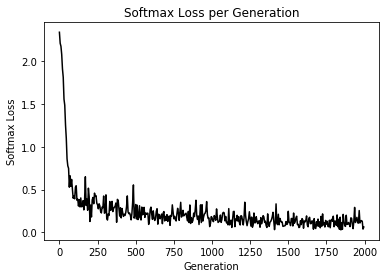

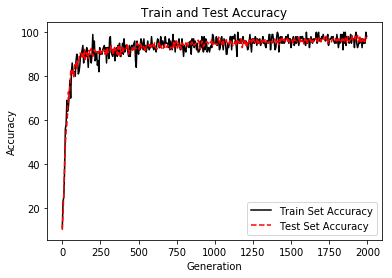

In [15]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss_2, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc_2, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc_2, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Model 3 Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions

In [16]:
def model_3_build(input_data, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias, new_relu = False):

    
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')
    if new_relu == True:
        max_pool1 = tf.nn.lrn(max_pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75)

    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')
    if new_relu == True:
        max_pool2 = tf.nn.lrn(max_pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75)
     
    final_conv_shape = max_pool2.get_shape().as_list()
    modified_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], modified_shape])

    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))

    model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    return model_output

In [17]:
def model_3(train_data, train_labels, test_data, test_labels, generations, new_relu = False):
    sess = tf.Session()
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
    conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
    conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
    conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

    resulting_width = image_width // (max_pool_size1 * max_pool_size2)
    resulting_height = image_height // (max_pool_size1 * max_pool_size2)
    full1_input_size = resulting_width * resulting_height * conv2_features
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

    model_output = model_3_build(x_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias, new_relu)
    test_model_output = model_3_build(eval_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias, new_relu)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    # Initialize Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(test_data), size=evaluation_size)
            eval_x = test_data[eval_index]
            eval_x = np.expand_dims(eval_x, 3)
            eval_y = test_labels[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        if (i+1) % 200 == 0:
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    sess.close()
    return train_loss, train_acc, test_acc


In [18]:
%%time
train_loss_3, train_acc_3, test_acc_3 = model_3(train_set_n, train_labels, test_set_n, test_labels, generations)

model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)
Generation # 200. Train Loss: 0.33. Train Acc (Test Acc): 90.00 (93.20)
Generation # 400. Train Loss: 0.09. Train Acc (Test Acc): 97.00 (96.20)
Generation # 600. Train Loss: 0.15. Train Acc (Test Acc): 96.00 (94.20)
Generation # 800. Train Loss: 0.07. Train Acc (Test Acc): 98.00 (98.60)
Generation # 1000. Train Loss: 0.10. Train Acc (Test Acc): 97.00 (98.40)
Generation # 1200. Train Loss: 0.10. Train Acc (Test Acc): 98.00 (98.20)
Generation # 1400. Train Loss: 0.05. Train Acc (Test Acc): 98.00 (98.40)
Generation # 1600. Train Loss: 0.11. Train Acc (Test Acc): 97.00 (97.60)
Generation # 1800. Train Loss: 0.03. Train Acc (Test Acc): 99.00 (98.20)
Generation # 2000. Train Loss: 0.05. Train Acc (Test Acc): 99.00 (98.20)
Wall time: 14.4 s


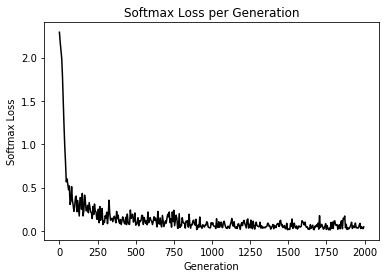

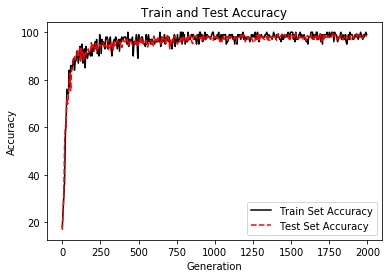

In [19]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss_3, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc_3, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc_3, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Compare three models 

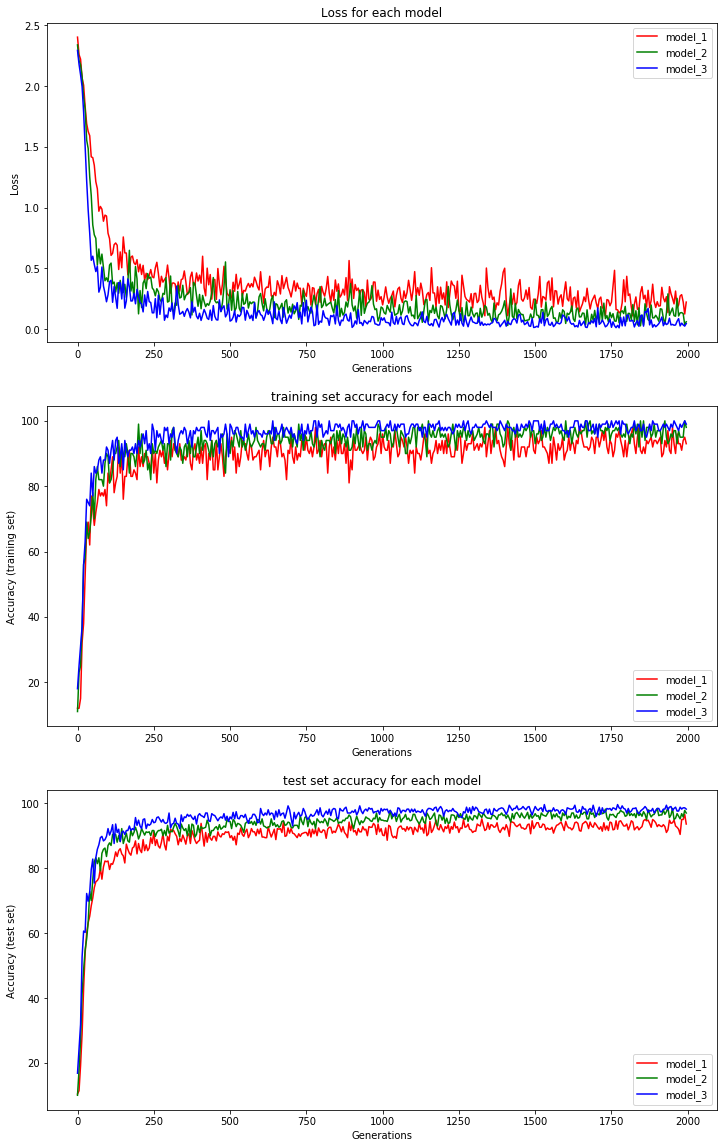

Test set accuracy (model 1): 93.6
Test set accuracy (model 2): 97.0
Test set accuracy (model 3): 98.2


In [20]:
plt.rcParams["figure.figsize"] = [12,20]

plt.subplot(311)
plt.plot(eval_indices, train_loss_1, 'r', label='model_1')
plt.plot(eval_indices, train_loss_2, 'g', label='model_2')
plt.plot(eval_indices, train_loss_3, 'b', label='model_3')
plt.title('Loss for each model')
plt.xlabel('Generations')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim(0, 5)

plt.subplot(312)
plt.plot(eval_indices, train_acc_1, 'r', label='model_1')
plt.plot(eval_indices, train_acc_2, 'g', label='model_2')
plt.plot(eval_indices, train_acc_3, 'b', label='model_3')
plt.title('training set accuracy for each model')
plt.xlabel('Generations')
plt.legend(loc='lower right')
plt.ylabel('Accuracy (training set)')
#plt.ylim(0, 5)

plt.subplot(313)
plt.plot(eval_indices, test_acc_1, 'r', label='model_1')
plt.plot(eval_indices, test_acc_2, 'g', label='model_2')
plt.plot(eval_indices, test_acc_3, 'b', label='model_3')
plt.title('test set accuracy for each model')
plt.xlabel('Generations')
plt.legend(loc='lower right')
plt.ylabel('Accuracy (test set)')
#plt.ylim(0, 5)

plt.show()

print('Test set accuracy (model 1): {}'.format(test_acc_1[-1]))
print('Test set accuracy (model 2): {}'.format(test_acc_2[-1]))
print('Test set accuracy (model 3): {}'.format(test_acc_3[-1]))

## Visualize wronge predictions 

In [21]:
def get_wronge_predictions(train_data, train_labels, test_data, test_labels, generations):
    sess = tf.Session()
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
    conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
    conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
    conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

    resulting_width = image_width // (max_pool_size1 * max_pool_size2)
    resulting_height = image_height // (max_pool_size1 * max_pool_size2)
    full1_input_size = resulting_width * resulting_height * conv2_features
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

    model_output = model_3_build(x_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    test_model_output = model_3_build(eval_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    # Initialize Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

       
    eval_index = np.random.choice(len(test_data), size=evaluation_size)
    eval_x = test_data[eval_index]
    eval_x = np.expand_dims(eval_x, 3)
    eval_y = test_labels[eval_index]
    test_dict = {eval_input: eval_x, eval_target: eval_y}
    test_preds = sess.run(test_prediction, feed_dict=test_dict)
    
    batch_predictions = np.argmax(test_preds, axis=1)
    not_match = ~np.equal(batch_predictions, eval_y)
    x = eval_x[not_match]
    true_y = eval_y[not_match]
    predict_y = batch_predictions[not_match]
    sess.close()
    
    return x, true_y, predict_y


In [22]:
x_img, true_y, predict_y = get_wronge_predictions(train_set, train_labels, test_set, test_labels, generations)

model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)


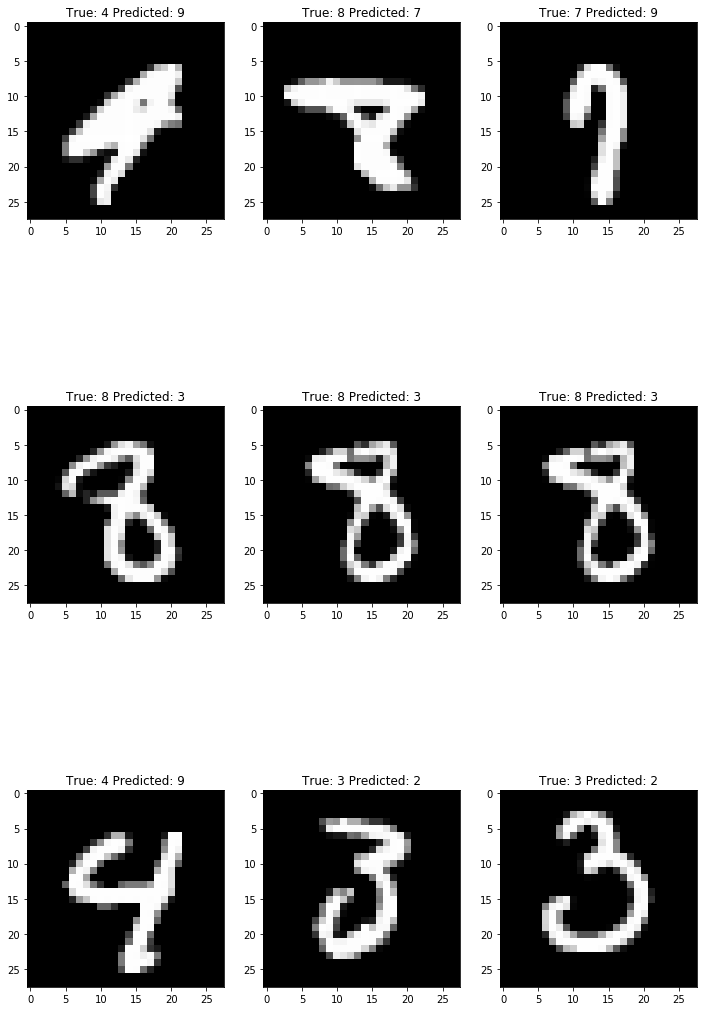

In [23]:
Nrows = 3
Ncols = 3
for i in range(9):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(x_img[i], [28,28]), cmap='Greys_r')
    plt.title('True: ' + str(true_y[i]) + ' Predicted: ' + str(predict_y[i]),fontsize=12)
plt.show()

## Further discussion based on model 3


*   Train model with unnorlamized data
*   Train model with normalized data
*   Train model with new relu and noemalized data



In [24]:
%%time
train_loss_3_non, train_acc_3_non, test_acc_3_non = model_3(train_set_n, train_labels, test_set_n, test_labels, generations)

model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)
Generation # 200. Train Loss: 0.18. Train Acc (Test Acc): 94.00 (91.40)
Generation # 400. Train Loss: 0.04. Train Acc (Test Acc): 100.00 (93.60)
Generation # 600. Train Loss: 0.15. Train Acc (Test Acc): 97.00 (96.00)
Generation # 800. Train Loss: 0.06. Train Acc (Test Acc): 99.00 (96.60)
Generation # 1000. Train Loss: 0.15. Train Acc (Test Acc): 95.00 (96.40)
Generation # 1200. Train Loss: 0.09. Train Acc (Test Acc): 97.00 (97.60)
Generation # 1400. Train Loss: 0.05. Train Acc (Test Acc): 98.00 (98.20)
Generation # 1600. Train Loss: 0.04. Train Acc (Test Acc): 99.00 (97.40)
Generation # 1800. Train Loss: 0.04. Train Acc (Test Acc): 99.00 (97.80)
Generation # 2000. Train Loss: 0.04. Train Acc (Test Acc): 99.00 (99.20)
Wall time: 14 s


In [25]:
%%time
train_loss_3_new_relu, train_acc_3_new_relu, test_acc_3_new_relu = model_3(train_set_n, train_labels, test_set_n, test_labels, generations, new_relu = True)

model 3 (Convol_1 -> Maxpool_1 -> Convol_2 -> Maxpool_2 -> fully connect_1 -> fully connect_2 -> predictions)
Generation # 200. Train Loss: 0.32. Train Acc (Test Acc): 91.00 (91.40)
Generation # 400. Train Loss: 0.36. Train Acc (Test Acc): 88.00 (94.60)
Generation # 600. Train Loss: 0.13. Train Acc (Test Acc): 98.00 (96.20)
Generation # 800. Train Loss: 0.12. Train Acc (Test Acc): 97.00 (96.60)
Generation # 1000. Train Loss: 0.06. Train Acc (Test Acc): 99.00 (94.60)
Generation # 1200. Train Loss: 0.07. Train Acc (Test Acc): 99.00 (98.20)
Generation # 1400. Train Loss: 0.04. Train Acc (Test Acc): 99.00 (97.40)
Generation # 1600. Train Loss: 0.04. Train Acc (Test Acc): 99.00 (96.80)
Generation # 1800. Train Loss: 0.07. Train Acc (Test Acc): 96.00 (98.40)
Generation # 2000. Train Loss: 0.07. Train Acc (Test Acc): 98.00 (98.60)
Wall time: 18 s


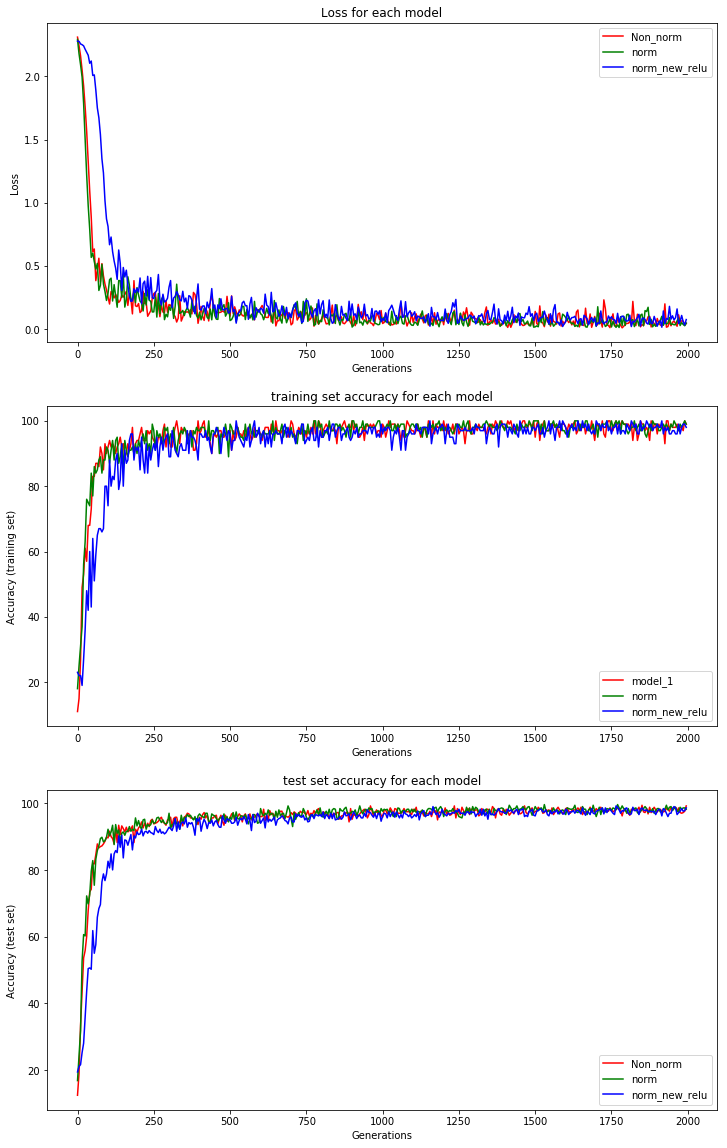

Test set accuracy (Non_norm): 99.2
Test set accuracy (norm): 98.2
Test set accuracy (norm_new_relu): 98.6


In [26]:
plt.rcParams["figure.figsize"] = [12,20]

plt.subplot(311)
plt.plot(eval_indices, train_loss_3_non, 'r', label='Non_norm')
plt.plot(eval_indices, train_loss_3, 'g', label='norm')
plt.plot(eval_indices, train_loss_3_new_relu, 'b', label='norm_new_relu')
plt.title('Loss for each model')
plt.xlabel('Generations')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim(0, 5)

plt.subplot(312)
plt.plot(eval_indices, train_acc_3_non, 'r', label='model_1')
plt.plot(eval_indices, train_acc_3, 'g', label='norm')
plt.plot(eval_indices, train_acc_3_new_relu, 'b', label='norm_new_relu')
plt.title('training set accuracy for each model')
plt.xlabel('Generations')
plt.legend(loc='lower right')
plt.ylabel('Accuracy (training set)')
#plt.ylim(0, 5)

plt.subplot(313)
plt.plot(eval_indices, test_acc_3_non, 'r', label='Non_norm')
plt.plot(eval_indices, test_acc_3, 'g', label='norm')
plt.plot(eval_indices, test_acc_3_new_relu, 'b', label='norm_new_relu')
plt.title('test set accuracy for each model')
plt.xlabel('Generations')
plt.legend(loc='lower right')
plt.ylabel('Accuracy (test set)')
#plt.ylim(0, 5)

plt.show()

print('Test set accuracy (Non_norm): {}'.format(test_acc_3_non[-1]))
print('Test set accuracy (norm): {}'.format(test_acc_3[-1]))
print('Test set accuracy (norm_new_relu): {}'.format(test_acc_3_new_relu[-1]))